I used this to attempt to build a wasserstein unconditional GAN to train my highways on. Note it does not converge so I did not end up using it in my report.

Starting from: https://bytepawn.com/training-a-pytorch-wasserstain-mnist-gan-on-google-colab.html

In [ ]:
import os
import numpy as np
import math
import sys
from time import time
import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

os.makedirs("images", exist_ok=True)

class Opt(object):
    dim = 10
    n_epochs = 20000
    batch_size = dim*dim
    lr = 0.00005
    n_cpu = 1
    latent_dim = 100
    img_size = 256
    channels = 1
    n_critic = 5
    clip_value = 0.01
    sample_interval = 400
opt = Opt()  

img_shape = (opt.channels, opt.img_size, opt.img_size)

cuda = True if torch.cuda.is_available() else False

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(opt.latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(opt.img_size ** 2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )
    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()
transform = transforms.Compose([transforms.Grayscale(),transforms.RandomHorizontalFlip(),transforms.RandomRotation(90),transforms.
                                 transforms.ToTensor()])
dataset = datasets.ImageFolder('/content/drive/MyDrive/BayAreaHighway250Mask2',transform=transform)

if cuda:
    generator.cuda()
    discriminator.cuda()

# Configure data loader
#os.makedirs("../../data/mnist", exist_ok=True)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=opt.batch_size,
    shuffle=True,
)

#os.makedirs("../../data/mnist", exist_ok=True)
#dataloader = torch.utils.data.DataLoader(
#    datasets.MNIST(
#        "../../data/mnist",
#        train=True,
#        download=True,
#        transform=transforms.Compose([transforms.Resize(256),transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
#    ),
#    batch_size=opt.batch_size,
#    shuffle=True,
#)

# Optimizers
generator_optimizer = torch.optim.RMSprop(generator.parameters(), lr=opt.lr)
discriminator_optimizer = torch.optim.RMSprop(discriminator.parameters(), lr=opt.lr)

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

# ----------
#  Training
# ----------

batches_done = 0
saved_imgs = []
for epoch in range(opt.n_epochs):
    print('Epoch ' + str(epoch) + ' training...' , end=' ')
    start = time()
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = Variable(imgs.type(Tensor))
        # train Discriminator
        discriminator_optimizer.zero_grad()
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], opt.latent_dim))))
        #print(z.size())
        # generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        discriminator_loss = torch.mean(discriminator(fake_imgs)) - torch.mean(discriminator(real_imgs)) 
        discriminator_loss.backward()
        discriminator_optimizer.step()
        # clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-opt.clip_value, opt.clip_value)
        # train the generator every n_critic iterations
        if i % opt.n_critic == 0:
            # train Generator
            generator_optimizer.zero_grad()
            # generate a batch of fake images
            critics_fake_imgs = generator(z)
            # Adversarial loss
            generator_loss = -torch.mean(discriminator(critics_fake_imgs))
            generator_loss.backward()
            generator_optimizer.step()
        batches_done += 1
    end = time()
    elapsed = end - start
    print('done, took %.1f seconds.' % elapsed)
    grid = torchvision.utils.make_grid(critics_fake_imgs.data.cpu(), nrow=opt.dim)
    img = (np.transpose(grid.detach().numpy(), (1, 2 ,0)) * 255).astype(np.uint8)
    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


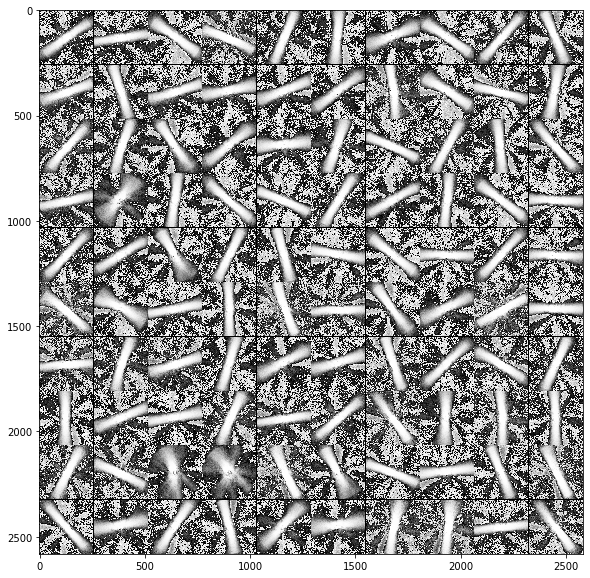

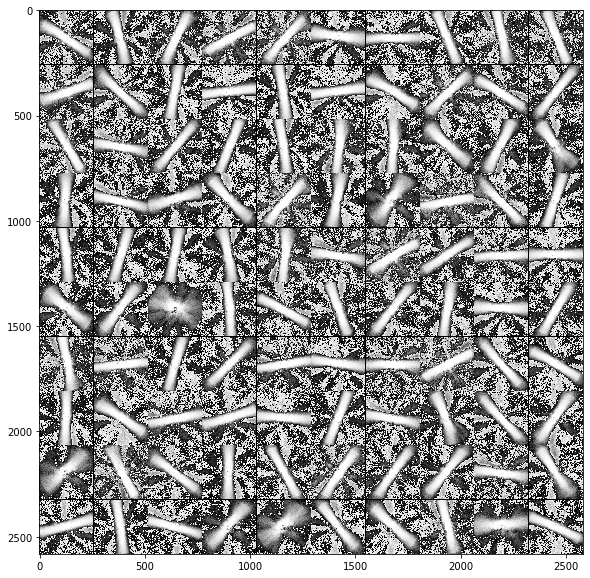

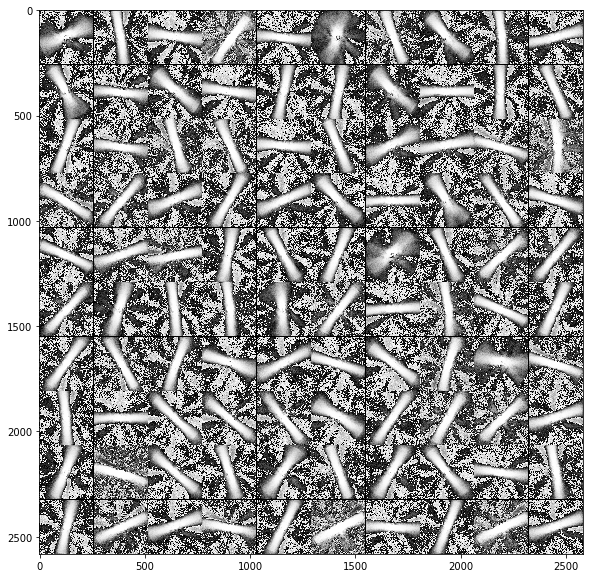

In [ ]:
img_indexes = [0, 1, 2]
for i in img_indexes:
    plt.figure(figsize = (opt.dim, opt.dim))
    plt.imshow(saved_imgs[i], interpolation='nearest')